In [6]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [7]:
# ee.Authenticate() # comentar
ee.Initialize()

In [8]:
min_lon, min_lat = -70.95, -33.65
max_lon, max_lat = -70.445, -33.325

santiago_bbox = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
emb_col = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
emb_2024 = emb_col.filterDate('2024-01-01', '2025-01-01').mosaic()

In [9]:
sample_fc = (
    emb_2024.sample(
        region=santiago_bbox,
        scale=10,
        numPixels=5000,
        geometries=True
    )
)

sample_dict = sample_fc.getInfo()

rows = []
for feat in sample_dict["features"]:
    props = feat["properties"]
    lon, lat = feat["geometry"]["coordinates"]
    props["lon"] = lon
    props["lat"] = lat
    rows.append(props)

gdf = gpd.GeoDataFrame(rows, geometry=[Point(xy) for xy in zip([r["lon"] for r in rows], [r["lat"] for r in rows])], crs="EPSG:4326")
gdf_aligned = gdf.to_crs(epsg=3857)

In [10]:
comunas = gpd.read_file("../data/comunas_filtradas.gpkg")

gdf_subset = gpd.sjoin(
    gdf_aligned,
    comunas[["Comuna", "geometry"]],
    how="inner",
    predicate="within"
)

gdf_subset = gdf_subset.drop(columns=["index_right"], errors="ignore")
gdf_subset.to_file("../data/embeddings_alpha_earth.gpkg", driver="GPKG")
print(gdf_subset.shape)

(3887, 68)


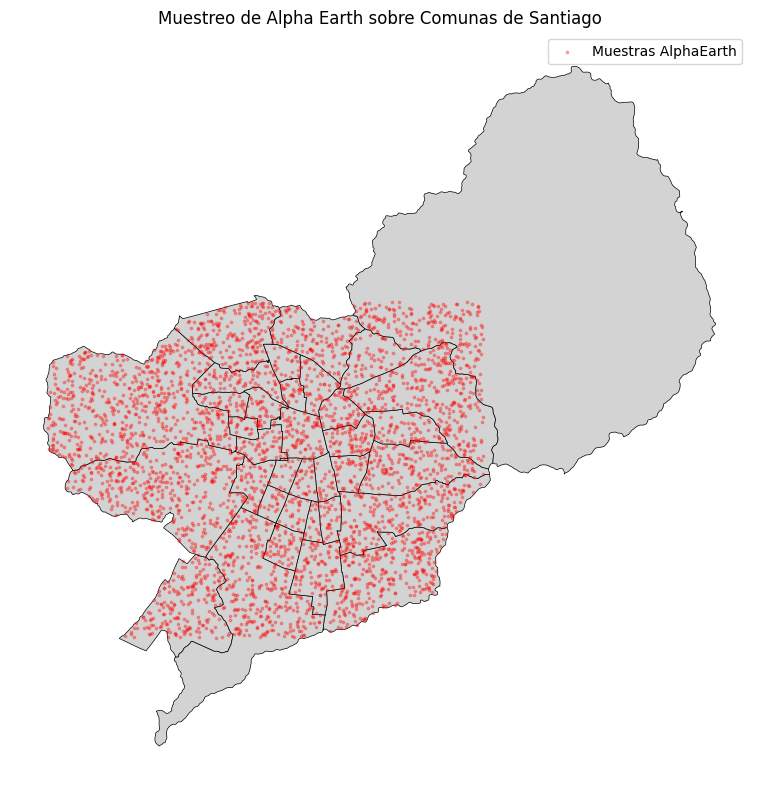

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
comunas.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
ax.scatter(
    gdf_subset.geometry.x,
    gdf_subset.geometry.y,
    s=3,
    alpha=0.3,
    color="red",
    label="Muestras AlphaEarth"
)

ax.set_title("Muestreo de Alpha Earth sobre Comunas de Santiago", fontsize=12)
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()
